In [1]:
# RT PIC - classic and nearest neighbour
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np
import os
import time
import h5py

In [2]:
CASE = 1

outputPath = 'CrameriOutput/'
tempPath = 'temp/'
outputFile = 'results_case' + str(CASE) + '.dat'

In [3]:
# make directories if they don't exist
if not os.path.isdir(outputPath):
    os.makedirs(outputPath)
if not os.path.isdir(tempPath):
    os.makedirs(tempPath)    

In [4]:
dim = 2

In [5]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType=("Q1/dQ0"),  
                                         elementRes=(384,192), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(28e5,7e5)  )
linearMesh   = elementMesh
constantMesh = elementMesh.subMesh

In [13]:

# setup a new swarm. At this point there is no data in the swarm
SwarmForElementMesh = uw.swarm.Swarm( feMesh=elementMesh )
# setup an array containing the position data from the elementMesh data
SwarmCoords = elementMesh.data
# use this array to add particles to the newly created swarm
SwarmForElementMesh.add_particles_with_coordinates(SwarmCoords)

array([    0,     1,     2, ..., 74302, 74303, 74304], dtype=int32)

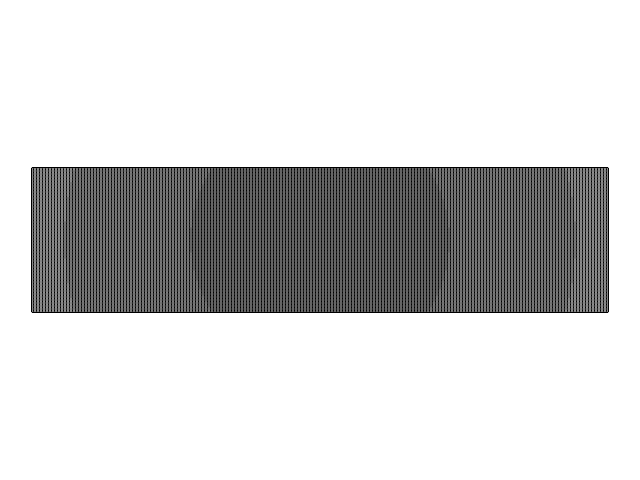

In [16]:
fig1 = plt.Figure()
fig1.Points( swarm=SwarmForElementMesh, pointSize=2, colour='blue', colourBar = False)
#fig1.Points( swarm=SwarmForConstantMesh, pointSize=10, colour='red', colourBar = False)
fig1.show()
 

In [6]:
# create fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=constantMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [7]:
#Boundary conditions

# Note that we use operator overloading to combine sets
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]
BWalls = linearMesh.specialSets["MinJ_VertexSet"]



#free sides, no slip top
mixedslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                                                  nodeIndexSets=(IWalls+BWalls, JWalls)  )

In [8]:
#uw.conditions.DirichletCondition?

In [9]:
#uw.shapes.BelowCosinePlane?

##Geometry

In [10]:
def below_cosine_func(x,y):
    if y < 7e3*math.cos(2*math.pi*(x/28e5)) + 7e5:
        return True
    else:
        return False

In [12]:
#cosineShape = uw.shapes.BelowCosinePlane(dim, amplitude=7e3, wavelength=28e5, offset=7e5)
maxCoord=(28e5,9e5)
below_cosine_func(maxCoord[0]/2., maxCoord[1]/2.)

True

##Particles

In [14]:
# We create swarms of particles which can advect, and which may determine 'materials'
gSwarm = uw.swarm.Swarm( feMesh=elementMesh )

# Now we add a data variable which will store an index to determine material
materialVariable = gSwarm.add_variable( dataType="char", count=1 )

# Layouts are used to populate the swarm across the whole domain
# Create the layout object
layout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=gSwarm, particlesPerCell=36 )
# Now use it to populate.
gSwarm.populate_using_layout(layout=layout )

# initialise the 'materialVariable' data to represent two different materials. 

mantleIndex = 1
lithosphereIndex = 2
airIndex = 3


# Set the material to air everywhere via the numpy array
materialVariable.data[:] = airIndex

In [15]:
for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
    x = gSwarm.particleCoordinates.data[particleID][0]
    y = gSwarm.particleCoordinates.data[particleID][1]
    if below_cosine_func(x,y):
        if gSwarm.particleCoordinates.data[particleID][1] > 6e5:
            materialVariable.data[particleID] =  lithosphereIndex
        else:
            materialVariable.data[particleID] =  mantleIndex

for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
    if cosineShape.pointInShape(tuple(gSwarm.particleCoordinates.data[particleID])):
        if gSwarm.particleCoordinates.data[particleID][1] > 6e5:
            materialVariable.data[particleID] =  lithosphereIndex
        else:
            materialVariable.data[particleID] =  mantleIndex

In [16]:
#fig1 = plt.Figure()
#fig1.Points( swarm=gSwarm, colourVariable=materialVariable )
#fig1.save_database('test_pol.gldb')
#fig1.show()

In [17]:
incr = 5000.
xps = np.linspace(0 + 1000.,28e5 - 1000., 10000)
yps = [7e5 + 7e3*np.cos(2*np.pi*(i/28e5)) for i in xps]

surfswarm = uw.swarm.Swarm( feMesh=elementMesh )
surfswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

array([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int32)

In [18]:
#fig2 = plt.Figure()
#fig2.Points( swarm=surfswarm, pointSize=2.0)
#fig2.Points( swarm=gSwarm, colourVariable=materialVariable )
#fig2.save_database('test_pol.gldb')
#fig1.save_database('test_pol.gldb')
#fig2.show()

##Material properties

In [19]:
print(1e23, 10.**23)

(1e+23, 1e+23)


In [20]:
#
viscosityMapFn  = fn.branching.map( keyFunc = materialVariable, 
                         mappingDict = {mantleIndex:1e21,airIndex:1e18,lithosphereIndex:1e23} )


densityMapFn = fn.branching.map( keyFunc = materialVariable,
                         mappingDict = {mantleIndex:3300.,airIndex:0., lithosphereIndex:3300.} )

# Define our gravity using a python tuple (this will be automatically converted to a function)
if dim ==2:
    gravity = ( 0.0, -10.0 )
else:
    gravity = ( 0.0, -10.0, 0.0)
    

# now create a buoyancy force vector.. the gravity tuple is converted to a function 
# here via operator overloading

buoyancyFn = gravity*densityMapFn

In [21]:
# Setup the Stokes system again, now with full viscosity
# For PIC style integration, we include a swarm for the a PIC integration swarm is generated within.
# For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[mixedslipBC,],
                              viscosityFn=fn.exception.SafeMaths(viscosityMapFn), 
                              bodyForceFn=buoyancyFn)

In [22]:
solver = uw.systems.Solver(stokesPIC)

In [23]:
solver.solve()

In [24]:
#fig3 = plt.Figure()
#fig3.Surface(pressureField, linearMesh)
#fig3.show()

In [25]:
# Create advector objects to advect the swarms. We specify second order integration.
advector1 = uw.systems.SwarmAdvector( swarm=gSwarm, velocityField=velocityField, order=2)
advector2 = uw.systems.SwarmAdvector( swarm=surfswarm, velocityField=velocityField, order=2)

In [26]:
def rms():
    squared = uw.utils.Integral(fn.math.dot(velocityField,velocityField), linearMesh)
    area = uw.utils.Integral(1.,linearMesh)
    return math.sqrt(squared.integrate()[0]/area.integrate()[0])

def avg_temp():
    temp = uw.utils.Integral(temperatureField, linearMesh)
    return temp.integrate()[0]

def maxtop():
    test = surfswarm.particleCoordinates.data
    return np.flipud(test[test[:,1].argsort()])[0:100,1].mean()
    

In [27]:
# Stepping. Initialise time and timestep.
realtime = 0.
step = 0

timevals = []
vrmsvals = []

In [ ]:
sectoka = (3600*24*365*1000)

In [ ]:
# create integral to get diff 
f_o = open(outputPath+outputFile, 'w')
fname = "topo.hdf5"
fullpath = os.path.join( tempPath+ fname)
start = time.clock()
while step<10:
    #stokesPIC2.solve(nonLinearIterate=True)
    solver.solve()
    dt1 = advector1.get_max_dt()
    dt = min((2.*sectoka),dt1)
    if step == 0:
        dt = 0.
    # Advect swarm using this timestep size
    advector1.integrate(dt)
    advector2.integrate(dt)
    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    #Save the suface swarm temporarily
    if uw.rank() == 0:
        surfswarm.save(fullpath)
        tempfile = h5py.File(fullpath, libver='latest')
        print tempfile.keys()
        maxt = tempfile["Position"][:][:,1].max()
        f_o.write((2*'%-15s ' + '\n') % (realtime,maxt))
        tempfile.close()
        os.remove(fullpath)
    print 'step =',step, 'time', realtime/sectoka

[u'OwningElement', u'Position']
step = 1 time 0.0
[u'OwningElement', u'Position']

In [ ]:
#tempfile = h5py.File(fullpath, libver='latest')

import matplotlib.pylab as pyplt

kms = [j/1000. - 700 for j in maxheight]

kyas = [i/sectoka for i in timevals]

#Analytic solution
y = -0.2139e-11
def analytic_height(y,t):
    return 7e3*math.exp(y*t)

ah = [analytic_height(y,i)/1000. for i in timevals]

uw_paper = np.loadtxt("./CASE1_data/UNDERWORLD_sa_100_18.dat")

%pylab inline
pyplt.plot(kyas, kms)
pyplt.plot(kyas, ah)
pyplt.plot(uw_paper[:,0], uw_paper[:,1])